# pyEDS_V1.0

By Xuyang (Rhett) Zhou, Max-Planck-Institut für Eisenforschung GmbH， x.zhou@mpie.de

pyEDS provides a systematic data processing approach to produce high-quality energy dispersive X-ray Spectroscopy (EDS) data analysis for material science study. Here we use the non-rigid registration (NRR) to reduce image distortion and non-local principal component analysis (NLPCA) to increase signal-to-noise ratio.

Here, I use a Sr-Ti-O (STO) sample for showing the work flow.

# 0.0 Load some module and parameters 

### Important note: Run the following cell twice to avoid imaging issues. 

In [2]:
## Figures in pop-out windows ###################################################
# %matplotlib qt
## Figures in the jupyter notebook #############################################
%matplotlib inline

import pyEDS.io as io
import hyperspy.api as hs
import matplotlib.pyplot as plt
hs.set_log_level('ERROR')

data_path = None            # Default, do not change
analysis_path = None        # Default, do not change
crop = None                 # Default, do not change
nrr_system = 'win_linux'      # 'windows' or 'linux' or 'win_linux'
nrr_cal_type = 'lambda'     # Either 'lambda' or 'frames'
set_lambda = 200            # Define the default value for NRR calculation，noraml ranging from 10-600
eds_bin = 9                 # Define the binning of energy spectrum, normally the original size is 4096
energy_low = 0.4            # Define the low boundary of energy spectrum unit: eV
energy_high = 9.4           # Define the width of energy spectrum unit: eV
band_list = [('Sr_La', 1.67, 1.94, 1.50000), ('Ti_Ka', 4.32, 4.67, 0.98200), ('O_Ka', 0.40, 0.62, 1.00000)] 
                            # (Element_Edge, Spectrum ranges low, Spectrum ranges high, and k-factor)

# 1.0 NRR calculation
In this step, the NRR calculation is performed to reduce the image distortion. 

This is a sluggish step. I usually prepare the job submission files for Linux calculations. Then I submit the jobs in the Linux system for NRR calculations. 

However, if you do not have access to the Linux system, you can also do the calculations in the Windows system. However, this is quite slow and does not support batch job submission. 

## 1.1 Load data
Here the input file is an ".emd" file used by the FEI TEMs

In [3]:
rSize = 128                  # Must be a power of 2, which is the size of your image. This is useful if your image is not a square shape. Make sure the longest side is a power of 2.
main_folder_path = 'STO/EDS/20220208_1847.emd'
# crop = [30,94,30,94]        # This is useful, if you only want to calculate a portion of your data. [left, right, top, bottom]

if nrr_system == 'windows':                                      ## For pure Windows system 
    system_path_1 = 'G:/pyEDS/'
    system_path_2 = system_path_1
    data_path = system_path_1 + main_folder_path                     
elif nrr_system == 'linux':                                      ## For pure Linux system
    system_path_1 = '/nethome/x.zhou/'                           ## For Linux system maws06
    # system_path_1 = '/cmmc/u/xuzhou/'                            ## For Linux system CMTI
    system_path_2 = system_path_1                             
    data_path = system_path_1 + 'TEM/nrr/' + main_folder_path      
elif nrr_system == 'win_linux':                                  ## For a mix of Windows and Linux system
    system_path_1 = '//mufs4/x.zhou/'                            ## For setting up calculation in Linux system maws06
    system_path_2 = '/nethome/x.zhou/'                           ## For Linux system maws06
    # system_path_1 = 'V:/u/xuzhou/'                               ## For setting up calculation in Linux system CMTI 
    # system_path_2 = '/cmmc/u/xuzhou/'                            ## For Linux system CMTI  
    data_path = system_path_1 + 'TEM/nrr/' + main_folder_path

## 1.2 Check Images

Original x dimension: 128
Original y dimension: 128
<LazySignal2D, title: HAADF, dimensions: (996|128, 128)>
<LazySignal2D, title: Sr, dimensions: (|128, 128)>
<LazySignal2D, title: O, dimensions: (|128, 128)>
<LazySignal2D, title: Ti, dimensions: (|128, 128)>
<LazySignal2D, title: DF4, dimensions: (996|128, 128)>
<LazyEDSTEMSpectrum, title: EDS, dimensions: (128, 128, 996|4096)>


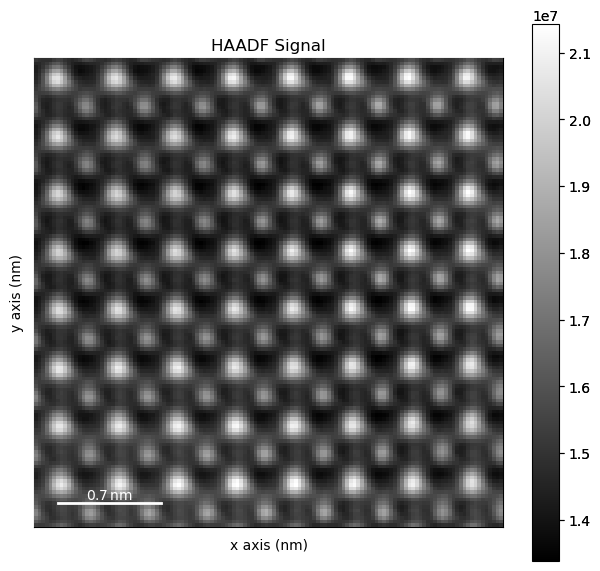

In [4]:
### Select a signal for analysis ################################################
signal = 'HAADF'                                      # Select a signal, normal I will choose the HAADF signal. 
#################################################################################
data, data_name,data_path,analysis_path = io.load_emd_lazy(data_path)
data, xDim, yDim = io.resize_data(data,rSize) 
analysis_path = io.analysis_path(data_name,signal,analysis_path)
data_signal = io.plot_signal(signal,data)
band_list = io.sort_band(band_list)

## 1.3 Set up for NRR running

### 1.3.1 Setting up a series of NRR calculation
There are three key parameters for NRR calculation. 
1. lambda: Determines the degree of local deformation that can be applied to correct distortion. 
2. numTemplates: Determine the number of frames you want to use for the NRR calculation. 
3. skip_frames: Determine the frames you want to omit from the NRR calculation.  

We support a systematic calculation to check the influence of parameters on the correction results. We provide two options: a. Changing a set of lambda values; b. Keeping lambda constant and changing the number of frames.  

In [5]:
if nrr_cal_type == 'lambda':
    group = 'lambda'
    # para = ['lambda_200']
    para = ['lambda_20','lambda_100','lambda_400','lambda_600']
elif nrr_cal_type == 'frames':
    set_lambda = 200                                          
    group = 'lambda' + str(set_lambda) + '_Frames'
    # para = ['numTemplates_100','numTemplates_200','numTemplates_300','numTemplates_400']  
skip_frames = []   ## example, [50,68]

### 1.3.2 Export each of the raw image
In this step, all raw images are exported. If you perform the calculations more than once, you may need to overlap the previous outputs. 

In [ ]:
calculation = io.nrr_setup(data_signal,analysis_path,set_lambda,skip_frames)

### 1.3.3 Generate Batch

This step prepares the files for the NRR calculation.

Very important note: You might need to change the job submission file based on your Linux system!!! 

Change it the "pyEDS/io.py" file, line #208-#230!!!

In [ ]:
io.generate_batch(analysis_path,group,para,nrr_system,system_path_1,system_path_2)

## 1.4 NRR running

In [ ]:
#### Set up parameters #########################################################
para_index = 1     
## In Windows you have to perform the NRR calculations one after the other by changing the "para_index"
## This is a very sluggish step, might take several hours. 
################################################################################
## For windows
if nrr_system == 'windows':
    io.run_win(calculation,analysis_path,group,para[para_index])
## For Linux
## If you can run the jobs in the Linux system, use the following code to submit the job(s). 
## -> cd ~/TEM/nrr/STO/20220208_1847/HAADF
## -> chmod 755 lambda_0.sh
## -> nohup ./lambda_0.sh &>/dev/null &

# This step is super slow!! Run it in Windows or Linux. Wait during it is running!

# 2.0 Quantify NRR (Optional)

This step is useful to check the quality of your NRR calculation. However, it is not mandatory. This step can be performed only after you have completed all calculations in the "group". 

All the images generated in this step have been automatically saved. 

//mufs4/x.zhou/TEM/nrr/STO/20220208_1847/HAADF\lambda\lambda_20\output\stage3\average.q2bz
//mufs4/x.zhou/TEM/nrr/STO/20220208_1847/HAADF\lambda\lambda_100\output\stage3\average.q2bz
//mufs4/x.zhou/TEM/nrr/STO/20220208_1847/HAADF\lambda\lambda_400\output\stage3\average.q2bz
//mufs4/x.zhou/TEM/nrr/STO/20220208_1847/HAADF\lambda\lambda_600\output\stage3\average.q2bz


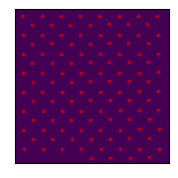

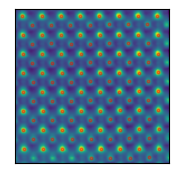

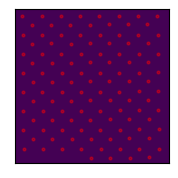

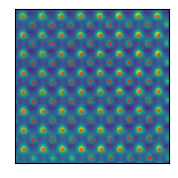

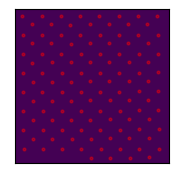

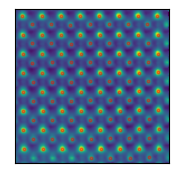

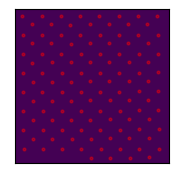

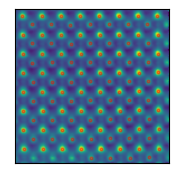

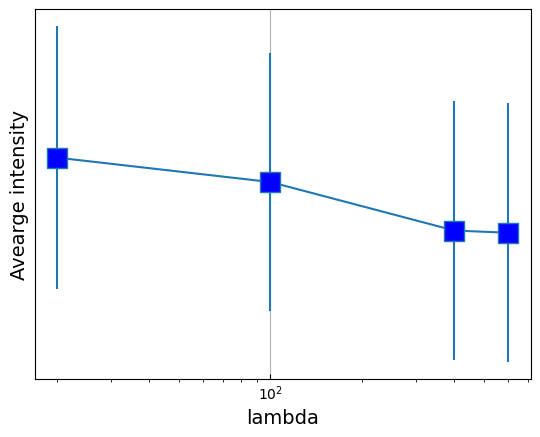

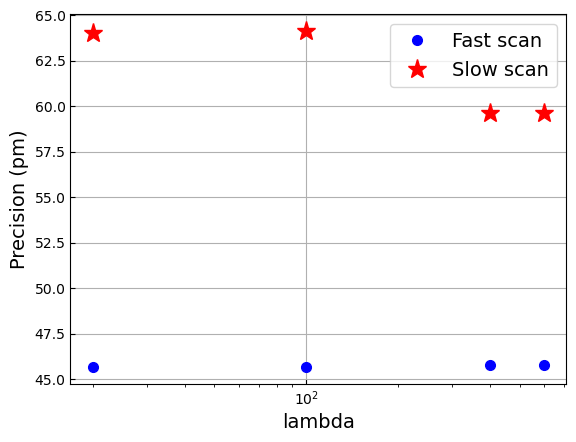

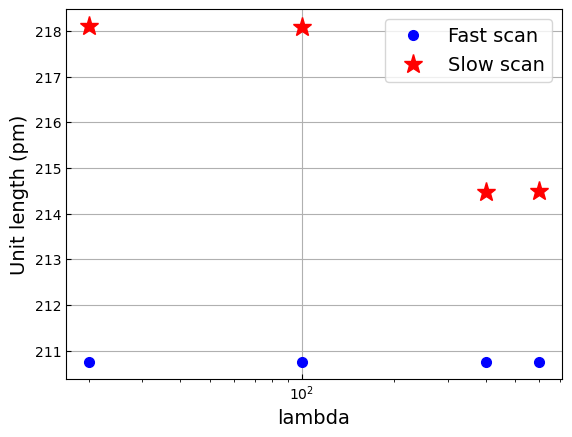

In [6]:
### Show the results of the quantification of NRR ##################################
min_distance = 4    ## This parameter is used for finding the peak positions of the atom columns
io.nrr_compare(analysis_path,group,para,data_signal,min_distance,xDim,yDim,crop,plot=1)
#####################################################################################

# 3.0 Apply NRR to EDS signal

In this step, the NRR deformation calculated from the HAADF signal is applied to the EDS signal.

This is also a time consuming step. It would be much better to perform this step in the Linux system. 

## 3.1a Apply deform

In this step, a file named as "corrected_spectrum.hspy" will be generated automatically.

### 3.1a-a For a single dataset

In [ ]:
## In Windows you have to perform the NRR calculations one after the other by changing the "para_index"
#### Apply NRR to spectrum, take time ###########################################
para_index = 1
subfolder,loaded = io.load_deform(analysis_path,group,para,para_index)
corrected_spectrum,spectrum_name = io.apply_deform_to_spectrum(eds_bin,energy_low,
        energy_high,analysis_path,subfolder,data,loaded,band_list,xDim,yDim,crop)
spectrum = corrected_spectrum                          # For corrected spectrum
#################################################################################

### 3.1a-b For a series of datasets in a certain group

In [ ]:
#### Apply NRR to spectrum, take time ###########################################
for i in range(len(para)):
    para_index = i
    subfolder,loaded = io.load_deform(analysis_path,group,para,para_index)
    corrected_spectrum,spectrum_name = io.apply_deform_to_spectrum(eds_bin,energy_low,
            energy_high,analysis_path,subfolder,data,loaded,band_list,xDim,yDim,crop)
io.generate_NPY_group(analysis_path,group,para,band_list,eds_bin,energy_low,energy_high,crop)
#################################################################################

## 3.1b Load an existing raw/deformed file

### 3.1b.a Load a raw spectrum

In this step, a file named as "raw_spectrum.hspy" will be generated automatically. This file is without NRR correction.

In [ ]:
# ----- Optional ----- #
### Rebin the raw spectrum ######################################################
raw_spectrum_load = io.load_emd(data_path)     # For raw spectrum
io.plot_intergrated_spectrum(raw_spectrum_load)
spectrum,raw_spectrum,spectrum_name = io.format_raw_spectrum(eds_bin,energy_low,energy_high,
        analysis_path,raw_spectrum_load,band_list,xDim,yDim,crop)
spectrum = raw_spectrum                                 # For raw spectrum
# plt.show()
##################################################################################

### 3.1b.b Load a deformed spectrum

In this step, you will be asked for selecting a '*.hspy' file. 

I found it is only possible to select file in the windows system! For Linux system, you need to give the path to io.load_corrected_spectrum(path). Here path is a string. 

In [7]:
# ----- Optional ----- #
### Select an existing corrected spectrum #######################################
corrected_spectrum,spectrum_name = io.load_corrected_spectrum()
spectrum = corrected_spectrum                          # For corrected spectrum
#################################################################################

## 3.2 Image the spectrum

Note: we have not done the denoising step yet. 

The output file for this step is a 'Denoise.npy' file. We will use this file for the denoising in Matlab.

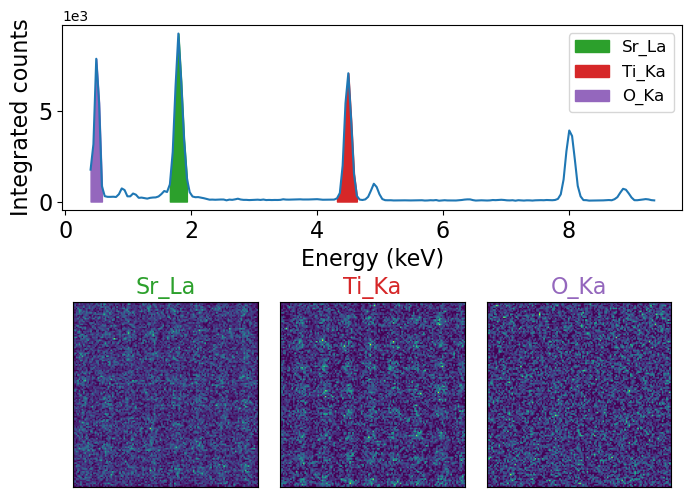

In [8]:
io.plot_eds_elemental_map(band_list,eds_bin,energy_low,spectrum,spectrum_name)
# spectrum.plot()

# Before the next step, you should go to Matlab and finish the NLPCA steps

# 4.0 After NLPCA denoising

This step can be done only after the NLPCA steps. Please refer to the Matlab section for the details.

## 4.1 Set up the parameters for imaging plotting

In [9]:
### Parameter setting ###########################################################
overlay_list = [0,1,2]                  # Determine which elements or lines to plot for overlapping
step = 8                                #  Determine the averaging of deformation, for NRR deformation
pre_blur=0                              #  For intensity and quantification, pre, before quantification
pre_G_blur=0                            #  Gaussian
post_blur=0                             #  post, after quantification
post_G_blur=0                           #  Gaussian
colorlist1 = ["cyan","orange","red"]    #  For overlaping images
colorlist = ["cyan","orange","red"]     #  For rescaled overlap images
##################################################################################

## 4.2a Plot for one condition

In this step you need to select the specific file "Denoise.mat" for the mapping. The output files will be all saved.

I found it is only possible to select file in the windows system! For Linux system, you need to give the path to io.load_NLPCA(path). Here path is a string. 

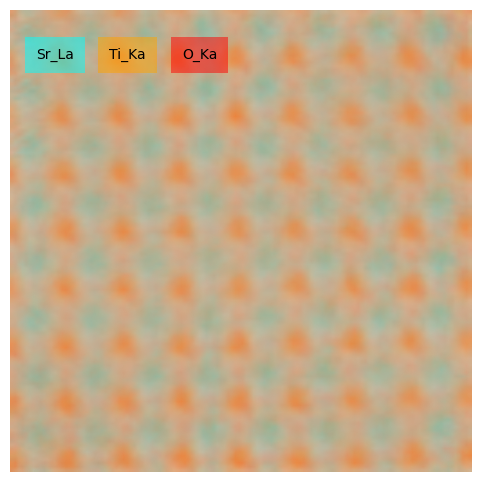

<Figure size 640x480 with 0 Axes>

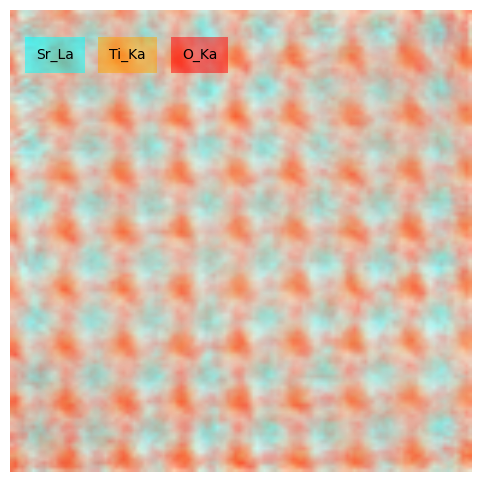

[########################################] | 100% Completed | 113.35 ms
[########################################] | 100% Completed | 117.43 ms
Sr: 22.6 %
Ti: 22.8 %
O: 54.6 %


<Figure size 640x480 with 0 Axes>

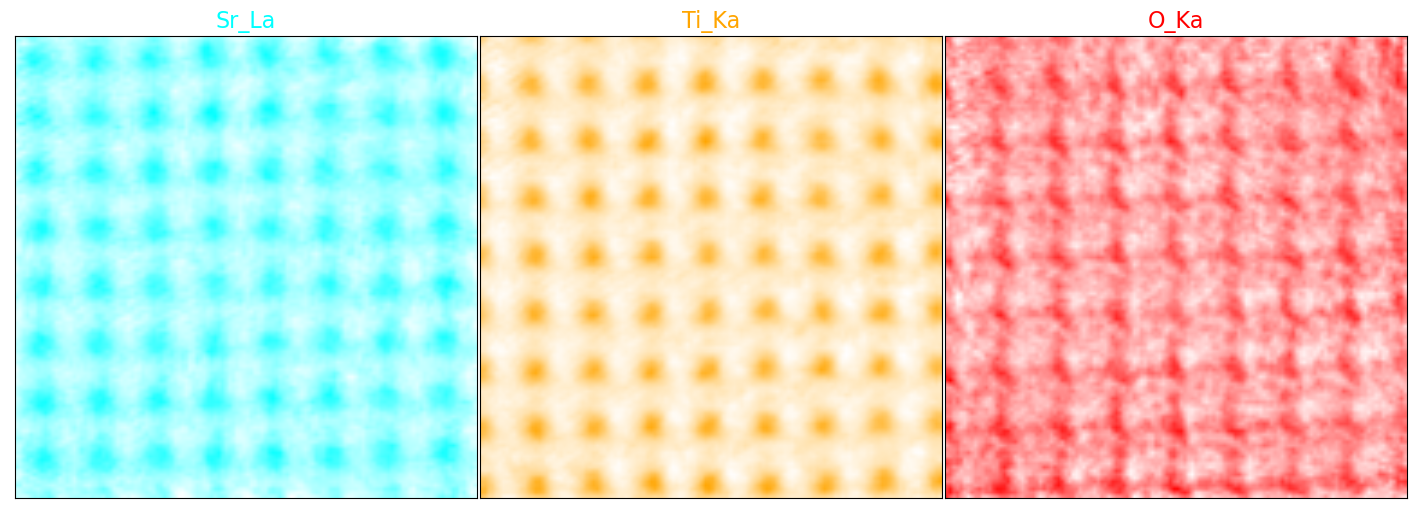

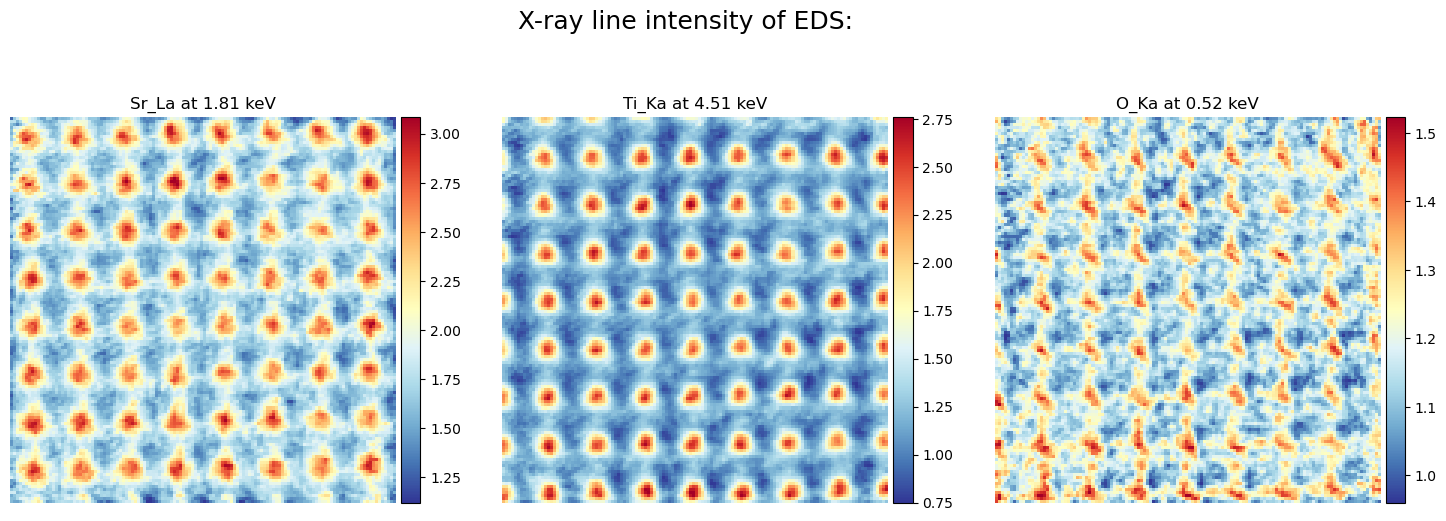

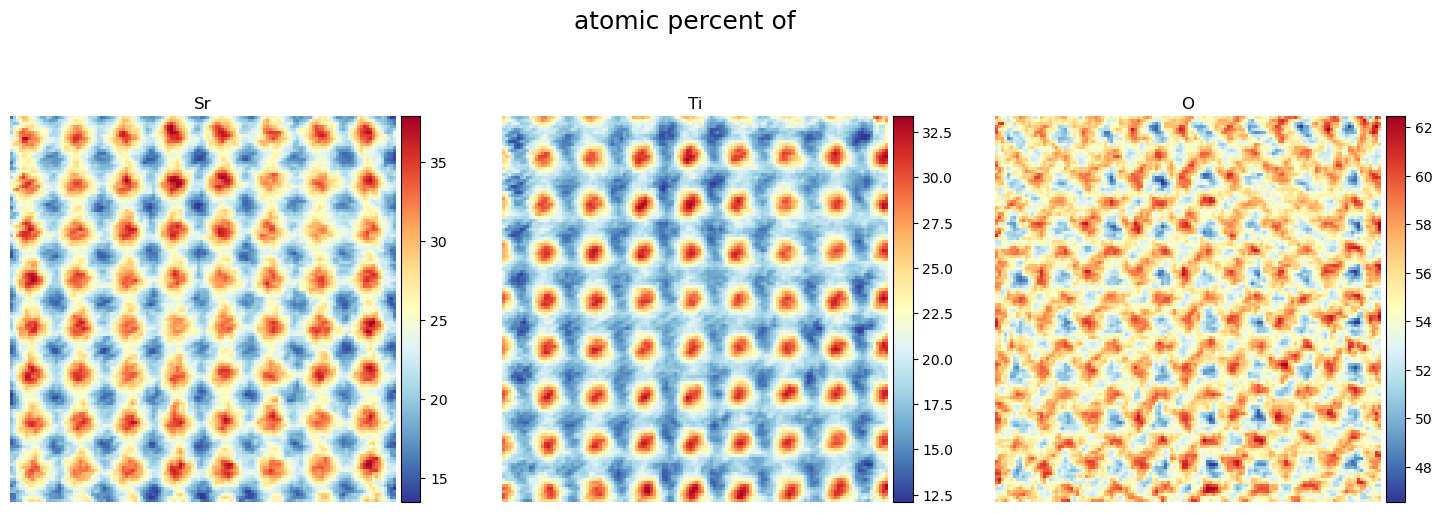

In [10]:
denoised, denoised_name = io.load_NLPCA()
io.plot_denoised_alpha(denoised,colorlist1,band_list,denoised_name,overlay_list,label=1)
io.plot_denoised_alpha(denoised,colorlist1,band_list,denoised_name,overlay_list,'rescale',label=1)
io.plot_element_denoised_alpha(denoised,colorlist,band_list,denoised_name,step)
atomic_percent_overall,inten,qual = io.EDS_quanty(band_list,denoised_name,denoised,pre_blur=pre_blur,
        pre_G_blur=pre_G_blur,post_blur=post_blur,post_G_blur=post_G_blur)

## 4.2b  Patch plot

In this step, all the conditions in the group will be plotted. Of course, the output files are all saved.

In [ ]:
io.load_NLPCA_group(analysis_path,group,para,colorlist1,colorlist,band_list,eds_bin,
        energy_low,energy_high,overlay_list,pre_blur,pre_G_blur,post_blur,post_G_blur,step,crop)

In [ ]:
plt.close('all')